<a href="https://colab.research.google.com/github/MohannadAshraf14/Scratch-VS-Transfer_xray/blob/main/Mohannad_Ashraf_Bone_Fructure_Detecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fracture-multi-region-x-ray-data


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from sklearn.model_selection import train_test_split
import os
import cv2
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, UnidentifiedImageError
import shutil
from shutil import copyfile
import plotly.express as px
import glob

# **Explore Data**

In [97]:
train=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
test=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
val=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'

In [98]:
os.listdir(train)

['not fractured', 'fractured']

In [99]:
fractured_train_path = os.path.join(train, 'fractured')
not_fractured_train_path = os.path.join(train, 'not fractured')

fractured_train_files = os.listdir(fractured_train_path)
not_fractured_train_files = os.listdir(not_fractured_train_path)

print(fractured_train_files[:5])
print(not_fractured_train_files[:5])
print(len(fractured_train_files))
print(len(not_fractured_train_files))

['9-rotated3-rotated1-rotated2 - Copy (1).jpg', '98-rotated1-rotated2-rotated1 (1).jpg', '79 - Copy (1).jpg', '1-rotated1-rotated1-rotated1 (1).jpg', '91-rotated1-rotated1-rotated2 (1).jpg']
['2-rotated3-rotated3-rotated2-rotated1 (2).jpg', '35-rotated2-rotated2.jpg', '70-rotated2-rotated1-rotated3-rotated1.jpg', '1-rotated1-rotated1-rotated1 (1).jpg', '19-rotated3-rotated2.jpg']
4606
4640


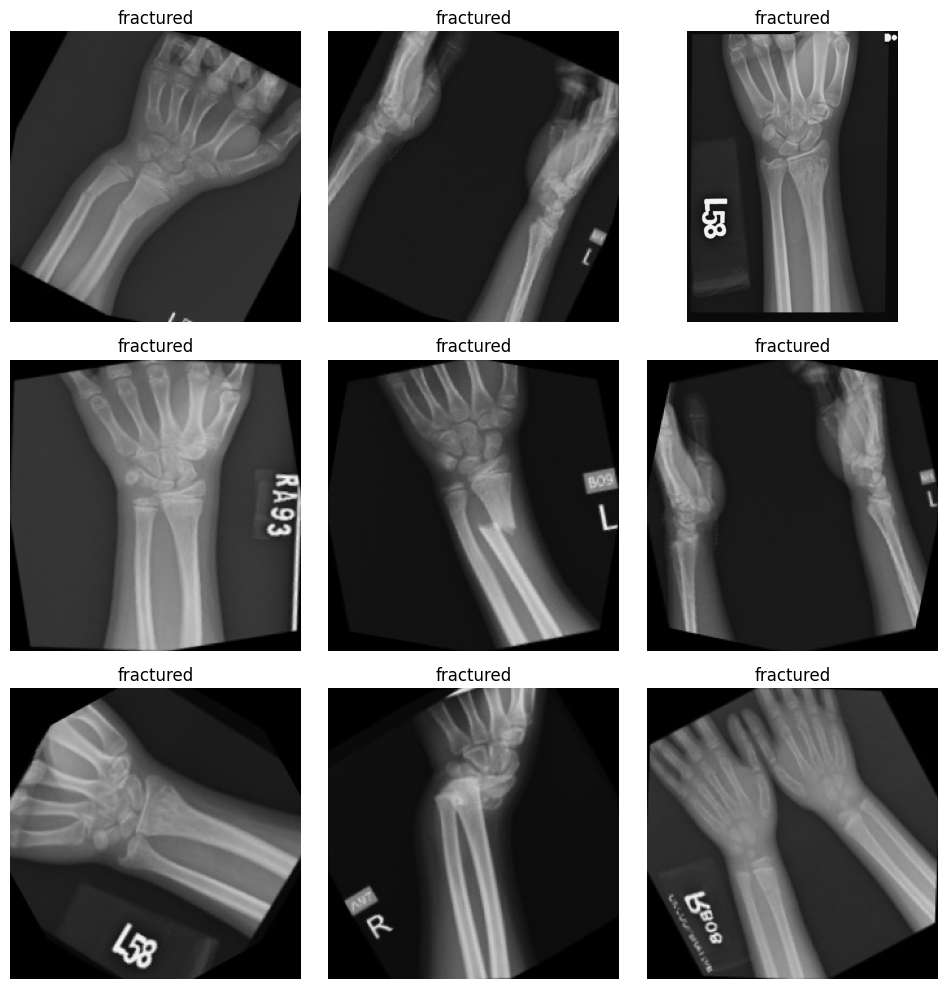

In [100]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(os.path.join(fractured_train_path, fractured_train_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('fractured')
    plt.tight_layout()
plt.show()

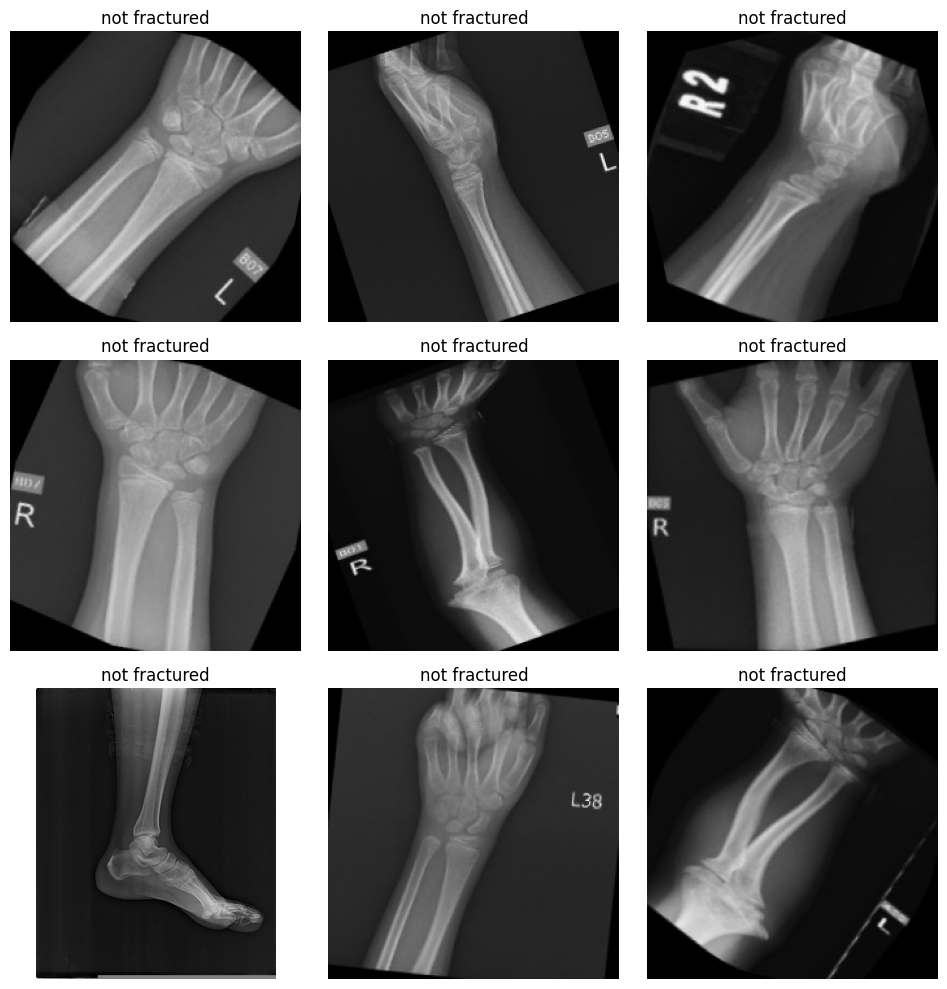

In [101]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(os.path.join(not_fractured_train_path, not_fractured_train_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('not fractured')
    plt.tight_layout()
plt.show()

In [102]:
labels = {'fractured':1, 'not fractured':0}
data = [train, test, val]

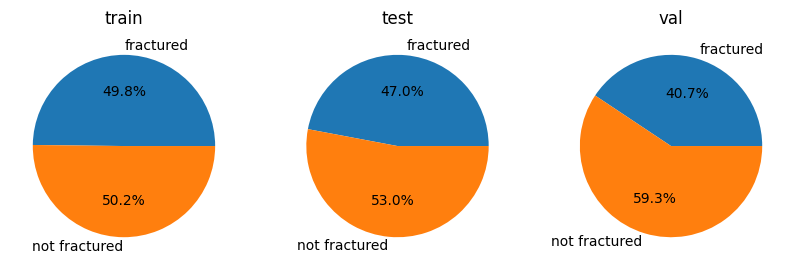

In [103]:
plt.figure(figsize=(10,10))
for i in data:
    plt.subplot(2, 3, data.index(i)+1)
    #pie
    n_fractured = len(os.listdir(i+'/fractured'))
    n_not_fractured = len(os.listdir(i+'/not fractured'))
    plt.pie([n_fractured, n_not_fractured], labels=labels.keys(), autopct='%1.1f%%')
    plt.title(i.split('/')[-1])
plt.show()

In [104]:
from PIL import ImageFile, UnidentifiedImageError

def remove_truncate(path):
    removed = 0
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            try:
                img = Image.open(os.path.join(path, folder, file))
                img.verify()
            except (UnidentifiedImageError, OSError, IOError, SyntaxError) as e:
                print('Bad file:', os.path.join(path, folder, file))
                os.remove(os.path.join(path, folder, file))
                removed += 1
    return removed
print(remove_truncate(train))
print(remove_truncate(test))
print(remove_truncate(val))

0
0
0


In [105]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
img_sizes =[]
for folder in os.listdir(train):
    for file in os.listdir(os.path.join(train, folder)):
      try:
        img = plt.imread(os.path.join(train, folder, file))
        img_sizes.append(img.shape)
      except Exception as e:
        print(e)

In [106]:
pd.Series(img_sizes).value_counts()

,count
"(224, 224, 3)",8538
"(454, 373, 3)",45
"(2880, 2304)",39
"(100, 100, 3)",11
"(373, 454, 3)",10
...,...
"(997, 972, 3)",1
"(2021, 1013)",1
"(1200, 840, 3)",1
"(871, 1024, 3)",1


# Prepare for training

In [107]:
print(len(os.listdir(train+'/fractured')))
print(len(os.listdir(train+'/not fractured')))
print(len(os.listdir(test+'/fractured')))
print(len(os.listdir(test+'/not fractured')))
print(len(os.listdir(val+'/fractured')))
print(len(os.listdir(val+'/not fractured')))

4606
4640
238
268
337
492


In [108]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(test,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')
validation_set = val_datagen.flow_from_directory(val,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


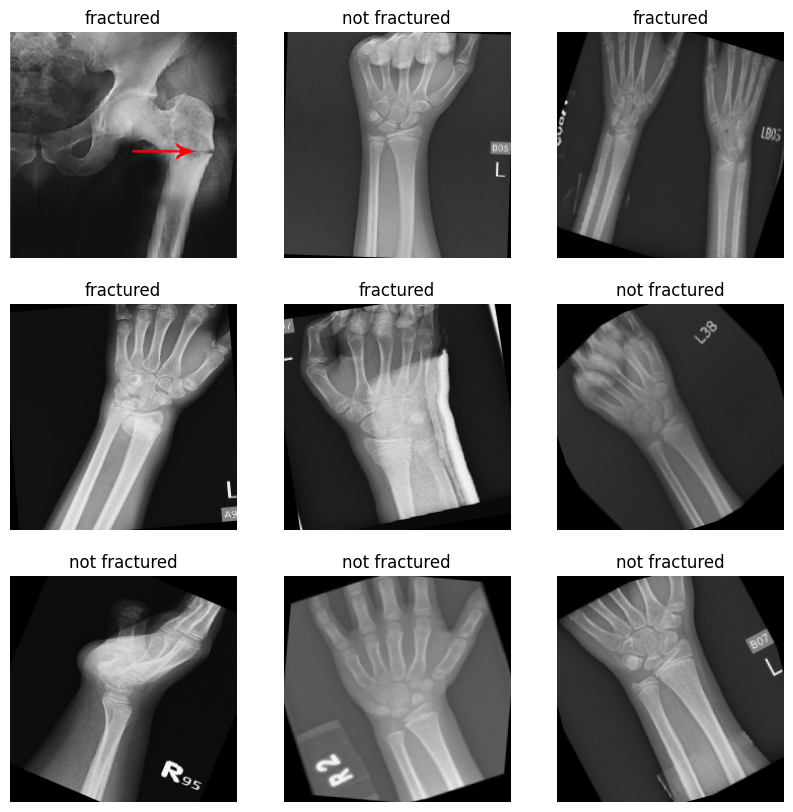

In [109]:
class_names = training_set.class_indices
class_names = {v: k for k, v in class_names.items()}
def plot_data(set, n_images):
    images, labels = next(set)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()
plot_data(training_set, 25)

# Train & Test

In [110]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 222, 222, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 222, 222, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 111, 111, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046,977 (3.99 MB)

 Trainable params: 1,046,465 (3.99 MB)

 Non-trainable params: 512 (2.00 KB)

In [111]:
improvements = [
    ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

In [112]:
history = model.fit(training_set, validation_data=validation_set, epochs=15, callbacks=improvements)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6249 - loss: 0.6384

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.70193, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 136s 208ms/step - accuracy: 0.6250 - loss: 0.6383 - val_accuracy: 0.6840 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 2/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8020 - loss: 0.4410
Epoch 2: val_loss improved from 0.70193 to 0.48369, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 175ms/step - accuracy: 0.8020 - loss: 0.4409 - val_accuracy: 0.7841 - val_loss: 0.4837 - learning_rate: 0.0010
Epoch 3/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8989 - loss: 0.2514
Epoch 3: val_loss did not improve from 0.48369
578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.8989 - loss: 0.2513 - val_accuracy: 0.6502 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 4/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9564 - loss: 0.1217
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.48369
578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9564 - loss: 0.1217 - val_accuracy: 0.7805 - val_loss: 0.7868 - learning_rate: 0.0010
Epoch 5/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9678 - loss: 0.0765
Epoch 5: val_loss improved from 0.48369 to 0.18937, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9678 - loss: 0.0764 - val_accuracy: 0.9168 - val_loss: 0.1894 - learning_rate: 5.0000e-04
Epoch 6/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9836 - loss: 0.0420
Epoch 6: val_loss improved from 0.18937 to 0.14452, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 175ms/step - accuracy: 0.9836 - loss: 0.0420 - val_accuracy: 0.9397 - val_loss: 0.1445 - learning_rate: 5.0000e-04
Epoch 7/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9871 - loss: 0.0399
Epoch 7: val_loss did not improve from 0.14452
578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.9871 - loss: 0.0399 - val_accuracy: 0.9083 - val_loss: 0.2694 - learning_rate: 5.0000e-04
Epoch 8/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9882 - loss: 0.0306
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_loss did not improve from 0.14452
578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9882 - loss: 0.0306 - val_accuracy: 0.9276 - val_loss: 0.2040 - learning_rate: 5.0000e-04
Epoch 9/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9907 - loss: 0.0253
Epoch 9: val_loss improved from 0.14452 to 0.12614, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 105s 181ms/step - accuracy: 0.9907 - loss: 0.0252 - val_accuracy: 0.9445 - val_loss: 0.1261 - learning_rate: 2.5000e-04
Epoch 10/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9946 - loss: 0.0168
Epoch 10: val_loss improved from 0.12614 to 0.09515, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.9626 - val_loss: 0.0951 - learning_rate: 2.5000e-04
Epoch 11/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9956 - loss: 0.0127
Epoch 11: val_loss did not improve from 0.09515
578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9956 - loss: 0.0127 - val_accuracy: 0.9457 - val_loss: 0.1195 - learning_rate: 2.5000e-04
Epoch 12/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9939 - loss: 0.0150
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 12: val_loss did not improve from 0.09515
578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 174ms/step - accuracy: 0.9939 - loss: 0.0150 - val_accuracy: 0.9421 - val_loss: 0.1672 - learning_rate: 2.5000e-04
Epoch 13/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9981 - loss: 0.0067
Epoch 13: val_loss improved from 0.09515 to 0.07116, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9710 - val_loss: 0.0712 - learning_rate: 1.2500e-04
Epoch 14/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9965 - loss: 0.0078
Epoch 14: val_loss did not improve from 0.07116
578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9965 - loss: 0.0078 - val_accuracy: 0.9735 - val_loss: 0.0742 - learning_rate: 1.2500e-04
Epoch 15/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9972 - loss: 0.0073
Epoch 15: val_loss improved from 0.07116 to 0.05930, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 100s 173ms/step - accuracy: 0.9972 - loss: 0.0073 - val_accuracy: 0.9771 - val_loss: 0.0593 - learning_rate: 1.2500e-04


# Evaluation

In [113]:
model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9804 - loss: 0.0475


[0.042540259659290314, 0.9822134375572205]

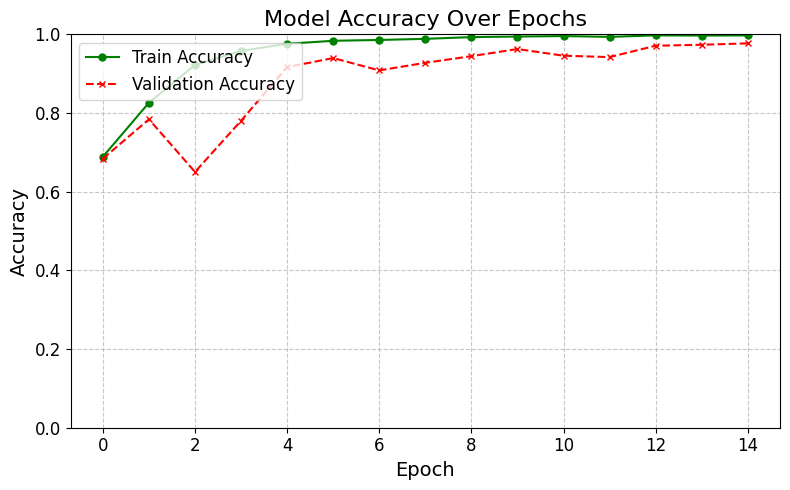

In [114]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


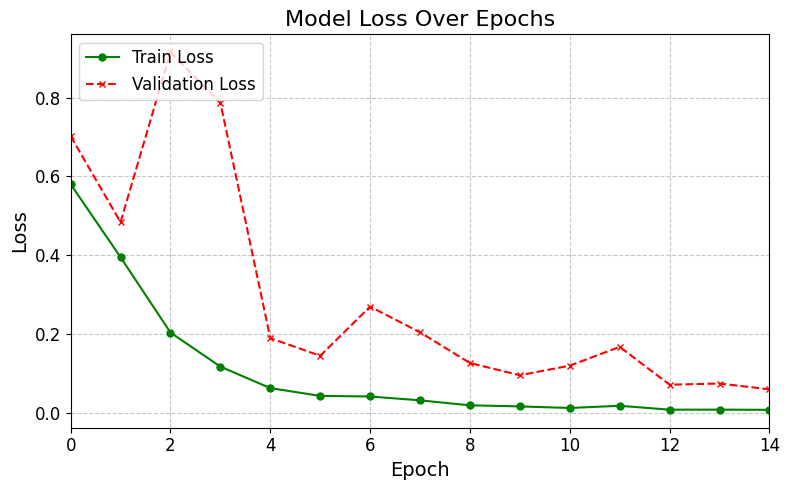

In [115]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


# Model by transfer learning

In [116]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [117]:
input_shape = (224, 224, 3)

In [118]:
xception_mode=Xception(weights='imagenet',include_top=False,input_shape=input_shape)
xception_mode.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_21[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [119]:
for layer in xception_mode.layers:
      if isinstance(layer, BatchNormalization):
          layer.trainable = True
      else:
          layer.trainable = False

In [120]:
model=Sequential()
x = GlobalAveragePooling2D()(xception_mode.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=xception_mode.input, outputs=output_layer)
model.summary()

Model: "functional_255"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_21[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 22,074,921 (84.21 MB)

 Trainable params: 1,267,969 (4.84 MB)

 Non-trainable params: 20,806,952 (79.37 MB)

In [121]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [122]:
history = model.fit(training_set, validation_data=validation_set, epochs=15, callbacks=improvements)

Epoch 1/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7548 - loss: 0.4627
Epoch 1: val_loss did not improve from 0.05930
578/578 ━━━━━━━━━━━━━━━━━━━━ 129s 176ms/step - accuracy: 0.7550 - loss: 0.4624 - val_accuracy: 0.9144 - val_loss: 0.2340 - learning_rate: 0.0010
Epoch 2/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9771 - loss: 0.0673
Epoch 2: val_loss did not improve from 0.05930
578/578 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - accuracy: 0.9771 - loss: 0.0673 - val_accuracy: 0.9614 - val_loss: 0.1371 - learning_rate: 0.0010
Epoch 3/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9824 - loss: 0.0501
Epoch 3: val_loss did not improve from 0.05930
578/578 ━━━━━━━━━━━━━━━━━━━━ 87s 150ms/step - accuracy: 0.9824 - loss: 0.0501 - val_accuracy: 0.9759 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 4/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9937 - loss: 0.0220
Epoch 4: val_loss did not improve from 0.05930
578/578 ━━━━━━━━━━━━━━━━━━

578/578 ━━━━━━━━━━━━━━━━━━━━ 87s 151ms/step - accuracy: 0.9953 - loss: 0.0164 - val_accuracy: 0.9916 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 7/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9959 - loss: 0.0158
Epoch 7: val_loss did not improve from 0.02746
578/578 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9959 - loss: 0.0158 - val_accuracy: 0.9916 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 8/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9978 - loss: 0.0099
Epoch 8: val_loss improved from 0.02746 to 0.01535, saving model to best_model.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 87s 150ms/step - accuracy: 0.9978 - loss: 0.0099 - val_accuracy: 0.9964 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 9/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9980 - loss: 0.0056
Epoch 9: val_loss did not improve from 0.01535
578/578 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.9940 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 10/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9969 - loss: 0.0101
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss did not improve from 0.01535
578/578 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9940 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 11/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9967 - loss: 0.0115
Epoch 11: val_loss did not improve from 0.01535
578/578 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9967 - loss: 0.0115 - v

In [123]:
model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9907 - loss: 0.0478


[0.04911494255065918, 0.9901185631752014]